In [1]:
#Import of all the necessary packages

import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm # Progress bar for loops
import networkx as nx # Tools to construct graphs and sample adjacency matrices
import os # To save the arrays we create


In [2]:
# Sampling on an Erdős-Rényi graph. We add a random weight between 0.1 and 1 to every edge created.
# Then, we check the eigenvalues of the adjacency matrix and rescale it so that the spectral radius is equal to 0.9,
# implying convergence in our model.

def weightedsampling(d, Nedges, drawing="no"):
    """
    Generate a weighted Erdős-Rényi graph and rescale the adjacency matrix.

    Parameters:
    d (int): Dimension of the system (number of nodes).
    Nedges (float): Average number of edges leaving a node.
    drawing (str): Flag to determine if the graph should be drawn ('yes' or 'no').

    Returns:
    np.ndarray: Rescaled adjacency matrix.
    networkx.DiGraph: graph linked to the adjacency matrix.
    """
    p = Nedges / d  # Calculate edge creation probability
    print("Sampling of the graph")
    
    G = nx.erdos_renyi_graph(d, p, directed=True)  # Generate Erdős-Rényi graph
    
    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.uniform(0.1, 1.0)  # Assign random weights to edges
    
    A = nx.to_numpy_array(G)  # Convert graph to adjacency matrix

    eigenvalues = np.linalg.eigvals(A)
    A = 0.9 / max(np.absolute(eigenvalues)) * A  # Set the spectral radius to 0.9
    
    # Reconstruct graph if required
    if drawing == "no":
        G_reconstructed = np.identity(d)
    else:
        G_reconstructed = nx.from_numpy_array(A, create_using=nx.DiGraph)
    
    print(G)
    return A, G_reconstructed

# Drawing of the graph. The small links do not get drawn.

def draw_graph(G, pos='not_set', ax=None, node_size=800, node_color='skyblue', font_size=10, font_color='black',
               edge_color='gray', edge_width=2.5, edge_alpha=0.8, threshold=0.02):
    """
    Draw the given graph with custom visual settings. residual links below a certain thresold do not get
    drawn.

    Parameters:
    G (networkx.DiGraph): The graph to be drawn.
    pos (dict or str): Node positions. If 'helper', generate positions using spring layout.
    ax (matplotlib.axes.Axes): Matplotlib Axes object to draw on.
    node_size (int): Size of the nodes.
    node_color (str): Color of the nodes.
    font_size (int): Font size of node labels.
    font_color (str): Font color of node labels.
    edge_color (str): Color of the edges.
    edge_width (float): Width of the edges.
    edge_alpha (float): Transparency of the edges.
    threshold (float): Threshold to determine which edges to draw based on weight. The value we chose is subjective.

    Returns:
    dict: Positions of the nodes.
    """
    spread_factor = 10  # Just for the graph to look better :-)
    
    if pos == 'not_set':  # Generate positions of the nodes in the graph if not provided
        pos = nx.spring_layout(G, k=spread_factor / np.sqrt(len(G.nodes())))
    
    # Draw nodes with customizations
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1, ax=ax)
    
    # Draw edges only if the weight is above the threshold
    for u, v, d in G.edges(data=True):
        if abs(d['weight']) > threshold:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width, edge_color=edge_color, alpha=edge_alpha, arrows=True, arrowsize=15, ax=ax)
            nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): "{:.2f}".format(d['weight'])}, font_size=font_size, font_color=font_color, ax=ax)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_color=font_color, ax=ax)
    
    ax.axis('off')  # Remove axis

    return pos


In [3]:
# Useful functions

def newA(A, d, beta):
    """
    Rescale the adjacency matrix for smoother process. beta is the number of points we compute 
    between two timesteps.
    X_{t+1} = (1 - 1 / beta) * Id * X_t + 1 / beta * f(X_t) generates X_{t+1} =
                                                [(1- 1 / beta) * Id + A / beta] * X_t + [sigma / beta] * xi_t

    Parameters:
    A (np.ndarray): Adjacency matrix.
    d (int): Dimension of the system.
    beta (float): Smoothing parameter. A larger beta results in smaller updates.
    

    Returns:
    np.ndarray: Rescaled adjacency matrix.
    """
    return (1 - 1 / beta) * np.identity(d) + A / beta


def power(A, time, d):
    """
    Compute the list of powers of a matrix, used to compute bias and variance for the response in the RM formalism.

    Parameters:
    A (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.

    Returns:
    np.ndarray: List of matrix powers.
    """
    list_power = np.zeros((time, d, d))
    list_power[0] = np.identity(d)
    for i in range(1, time):
        list_power[i] = list_power[i - 1] @ A
    return list_power

def sumpower(A, time, d):
    """
    Compute the cumulative sum of the outer products of the powers of the adjacency matrix.

    This function calculates the sum of squared powers used in the variance term 
    of the Random Matrix formalism. Specifically, it computes:
    Sum[i] = Sum[i-1] + (R^(i-1)) * (R^(i-1))^T

    Parameters:
    A (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.

    Returns:
    tuple: Sum of powers and list of powers of the matrix.
    """
    sum_power = np.zeros((time, d, d))
    list_power = power(A, time, d)
    for i in range(1, len(list_power)):
        sum_power[i] = sum_power[i - 1] + list_power[i-1] @ np.transpose(list_power[i-1])
    return sum_power, list_power

def solvediscretelyapunov(A, sigma, beta, tol=1e-15, max_iter=1000):
    r"""
    Solve the discrete Lyapunov equation to find the population matrix.
    C0 = sigma^2 / beta^2 * sum_{k=0}^{+ \infty} R^k R^k^T
    
    Parameters:
    A (np.ndarray): System matrix.
    sigma (float): Noise variance.
    beta (float): Smoothing parameter.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.

    Returns:
    np.ndarray: Solution to the Lyapunov equation.
    """
    A0 = A
    current_sum = np.identity(len(A[0]))
    
    for k in range(max_iter):
        term = A @ A.T
        A = A @ A0
        current_sum += term
        if np.linalg.norm(term, ord='fro') < tol:
            break
    return (sigma ** 2 / beta ** 2) * current_sum

def theoreticalcovariance(A, time, d, sigma, beta):
    """
    Compute the theoretical autocorrelation matrices of the vector autoregressive model of order 1.
    C_{t+1} = R @ C_t
    Parameters:
    A (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.
    sigma (float): Noise variance.
    beta (float): Smoothing parameter.

    Returns:
    np.ndarray: List of theoretical autocorrelation matrices.
    """
    Cth = np.zeros((beta * time, d, d))
    Cth[0] = solvediscretelyapunov(A, sigma, beta)
    for i in range(1, beta * time):
        Cth[i] = A @ Cth[i - 1]
    return Cth

def autocorrelationtime(Cth, time, beta, max_iter=1000, tol=1e-15):
    """
    Compute the autocorrelation time of the vector autoregressive model of order 1..

    Parameters:
    Cth (np.ndarray): List of theoretical autocorrelation matrices.
    time (int): Number of timesteps.
    beta (float): Smoothing parameter.
    max_iter (int): Maximum number of iterations.
    tol (float): Tolerance for convergence.

    Returns:
    tuple: Autocorrelation time.
    """
    lambdamaxlist = [np.real(max(np.linalg.eigvals(Cth[0])))]
    threshold = lambdamaxlist[0] / np.exp(1)
    autocorrtime = 0
    sumautocorr = 0
    
    for i in range(1, beta * time):
        lambdamaxlist.append(np.real(max(np.linalg.eigvals(Cth[i]))))
        if threshold < lambdamaxlist[i - 1] and threshold > lambdamaxlist[i]:
            autocorrtime = i
            break
    print("Autocorrelation time of the process =", autocorrtime)
            
    return autocorrtime

def convergence(A, sigma, beta, d, tconvergence=10**5):
    """
    Compute the convergence of the system to an attractor. No criteria is set for the convergence time. This can be a problem when beta is too big or sigma too small. 

    Parameters:
    A (np.ndarray): Adjacency matrix.
    beta (float): Smoothing parameter.
    sigma (float): Noise variance.
    d (int): Dimension of the system.
    tconvergence (int): Number of timesteps for convergence.

    Returns:
    np.ndarray: Final state vector.
    """
    X0 = np.random.normal(0, sigma, size=(d, 1))
    for _ in tqdm(range(beta * tconvergence)):
        xi = np.random.normal(0, sigma, size=(d, 1))
        X0 = A @ X0 + xi
    return X0

def computationX(X, smallA, xi, time, beta):
    """
    Compute the whole trajectory X based on the rescaled adjacency matrix and noise.

    Parameters:
    X (np.ndarray): Initial state vector.
    smallA (np.ndarray): Rescaled adjacency matrix.
    xi (np.ndarray): Noise matrix.
    time (int): Number of timesteps.
    beta (float): Smoothing parameter.

    Returns:
    np.ndarray: Updated sample matrix.
    """
    for j in tqdm(range(1,len(X[:,0,0]))):
        X[j, :, :] = smallA @ X[j - 1, :, :] + xi[j - 1, :, :] / beta
    return X

def computationCt(X, taverage, time, autocorrtime, beta):
    """
    Compute the empirical correlation matrices.

    Parameters:
    X (np.ndarray): Sample matrix.
    taverage (int): Number of iterations to average.
    time (int): Number of timesteps.
    autocorrtime (int): Autocorrelation time.
    beta (float): Smoothing parameter.

    Returns:
    np.ndarray: Empirical correlation matrices.
    """
    i = 0
    Ct = np.zeros((beta * time, d, d))
    for j in tqdm(range(autocorrtime*taverage)):
        if j % autocorrtime == 0:
            i += 1
            for t in range(0, beta * time):
                #print("t=",t)
                Ct[t, :, :] += X[j + t, :, :] @ np.transpose(X[j, :, :])
    return Ct, i 

def saving(X, A, xi, d, Nedges, taverage, alpha, beta, base_directory=r"/home/theomarchetta/Desktop/DOC théo/Stage/Data/"):
    """
    Save the adjacency matrix and the measures found.

    Parameters:
    X (np.ndarray): Sample matrix.
    A (np.ndarray): Adjacency matrix.
    xi (np.ndarray): Noise matrix.
    d (int): Dimension of the system.
    Nedges (float): Average number of edges leaving a node.
    taverage (int): Number of iterations to average.
    alpha (float): Hyperparameter contained in the loss function.
    beta (float): Smoothing parameter.
    base_directory (str): Base directory for saving files.
    """
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_alpha={alpha}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    if not os.path.exists(full_directory_path): #create the file
        os.makedirs(full_directory_path)
        
    Xfilename = f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}"
    Afilename = f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}"
    xifilename = f"noise_of_matrixsize={d}_averageconnectivity={Nedges}"
    
    Xfile_path = os.path.join(full_directory_path, Xfilename)
    Afile_path = os.path.join(full_directory_path, Afilename)
    xifile_path = os.path.join(full_directory_path, xifilename)
    
    np.savez_compressed(Xfile_path, X)
    np.savez_compressed(Afile_path, A)
    np.savez_compressed(xifile_path, xi)
    print("save successfully done")

def load_array(file_path):
    """
    Load data stored in npz format. This is a technical function to unpack the data, used in function loaddata.

    Parameters:
    file_path (str): Path to the npz file.

    Returns:
    np.ndarray: Loaded array.
    """
    with np.load(file_path) as data:
        array = data['arr_0']
    return array

def loaddata(d, Nedges, taverage, alpha, beta, base_directory=r"/home/theomarchetta/Desktop/DOC théo/Stage/Data"):
    """
    Load previously generated data.

    Parameters:
    d (int): Dimension of the system.
    Nedges (float): Average number of edges leaving a node.
    taverage (int): Number of iterations to average.
    alpha (float): Hyperparameter contained in the loss function.
    beta (float): Smoothing parameter.
    base_directory (str): Base directory for loading files.

    Returns:
    tuple: Sample matrix, adjacency matrix, and noise matrix.
    """
    print("Import of the data.")
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_alpha={alpha}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    
    Xfile_path = os.path.join(full_directory_path, f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npz")
    Afile_path = os.path.join(full_directory_path, f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npz")
    xifile_path = os.path.join(full_directory_path, f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npz")
    
    X = load_array(Xfile_path)
    A = load_array(Afile_path)
    xi = load_array(xifile_path)
    
    return X, A, xi


In [4]:
# Drawing function, used to plot the sampled and the inferred graph side to side.

def drawing_of_process(Rt, Ct, Cth, A, G_reconstructed, alpha, beta, ax):
    """
    Plot the sampled Erdos-Renyi graph and the inferred one one next to each other.

    Parameters:
    Rt (np.ndarray): Inferred response matrices.
    Ct (np.ndarray): Empirical correlation matrices.
    Cth (np.ndarray): Theoretical correlation matrices.
    A (np.ndarray): Adjacency matrix of the sampled graph.
    G_reconstructed (networkx.DiGraph): Reconstructed graph from R.
    alpha (float): Scaling factor for Rt.
    beta (float): Smoothing parameter.
    ax (np.ndarray): Array of matplotlib axes for plotting.
    """
    # Compute the inferred adjacency matrix
    A_inferred = ((1 / beta - 1) * np.identity(len(Rt[1, 0, :])) + Rt[1, :, :]) * beta #to go back from smallR to R,
                                                                #this is useful if beta is larger than 1.
    G_inferred = nx.from_numpy_array(A_inferred, create_using=nx.DiGraph)
    
    # Count the number of edges with significant weight
    count = 0
    for u, v, d in G_inferred.edges(data=True):
        if d['weight'] > beta * 0.02:
            count += 1
    
    print("Number of edges plotted =", count)
    
    # Draw the true response graph
    print("Drawing of the true response")
    pos = draw_graph(G_reconstructed, ax=ax[0])
    
    # Compute the difference between the true and inferred adjacency matrices
    print("Drawing of the difference between the true response matrix and the inferred one")
    G_reconstructedar = nx.to_numpy_array(G_reconstructed)
    diff = G_reconstructedar - A_inferred
    diffG = nx.from_numpy_array(diff, create_using=nx.DiGraph)
    
    # Draw the difference graph
    pos = draw_graph(diffG, pos, ax=ax[1])
    
    # Adjust plot margins for better spacing
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    
    # plt.savefig(f'graph_alpha_{alpha}.png')
    plt.show()



In [5]:
# Process function, used to empirically compute correlation matrices either by importing data or iterating the process from scratch.

def process(d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"):
    """
    Process function to compute empirical correlation matrices, either by importing data or iterating the process from scratch.

    Parameters:
    d (int): Dimension of the system.
    Nedges (int): Average number of edges leaving a node.
    alpha (float): Hyperparameter contained in the loss function.
    time (int): Number of timesteps.
    taverage (int): Number of iterations to average.
    sigma (float): Noise variance.
    beta (float): Smoothing parameter.
    load (str): "yes" to load data, "no" to generate new data.
    withsave (str): "yes" to save the generated data, "no" otherwise.
    drawing (str): "yes" to draw the graph, "no" otherwise.

    Returns:
    tuple: Computed Rt, Ct, Cth, X, autocorrtime, R, G_reconstructed, Neff, Neffunco.
    """
    
    # Construction of arrays and convergence to an attractor of the system.
    if load == "no":
        # Sampling of the graph.
        A, G_reconstructed = weightedsampling(d, Nedges, drawing)
        smallA = newA(A, d, beta)

        # Computation of Cth for each t.
        print("Computation of the theoretical autocorrelation matrix")
        Cth = theoreticalcovariance(smallA, 2 * time, d, sigma, beta) #2 * time bc usually autocorrtime is ~1 * time
        autocorrtime = autocorrelationtime(Cth, 2* time, beta)
        Cth = Cth[:beta * time, :, :]

        # Definition of the variables.
        X = np.zeros((autocorrtime*taverage + beta * time, d, 1))
        xi = np.random.normal(0, sigma, size=(autocorrtime* taverage + beta * time, d, 1))

        # Computation of the process
        print("Convergence to a fixed point")
        X[0, :] = convergence(A, sigma, beta, d)
        print("Computation of the process")
        X = computationX(X, smallA, xi, time, beta)

    
    else:
        X, A, xi = loaddata(d, Nedges, taverage, alpha, beta)
        smallA = newA(A, d, beta)
        if drawing == "no":
            G_reconstructed = np.identity(d)
        else:
            G_reconstructed = nx.from_numpy_array(A, create_using=nx.DiGraph)
        print("Data imported")

        # Computation of Cth for each t.
        print("Computation of the theoretical autocorrelation matrix")
        Cth = theoreticalcovariance(smallA, 2 * time, d, sigma, beta) #2 * time bc usually autocorrtime is ~1 * time
        autocorrtime = autocorrelationtime(Cth, 2* time, beta)
        Cth = Cth[:beta * time, :, :]

    
    print("Computation of Ct")
    Ct, Neff = computationCt(X, taverage, time, autocorrtime, beta)
    
    print("Neff =", Neff)
    Ct = Ct / Neff
    
    Rt = np.zeros((beta * time, d, d))
    for i in range(beta * time):
        Rt[i, :, :] = alpha * Ct[i, :, :] @ np.linalg.inv(np.identity(d) + alpha * Ct[0, :, :])
    
    # Save the dataset
    if withsave != "no" and load == "no":
        saving(X, A, xi, d, Nedges, taverage, alpha, beta)
    
    return Rt, Ct, Cth, X, autocorrtime, A, G_reconstructed, Neff

In [6]:
# Process function, used to compute the response using the RMT formalism.

def solve_fp_eq(eigen, alpha, rho, initial_guess, tol, max_iter):
    """
    Solve the fixed-point equation for the self-energy.

    Parameters:
    - eigen (ndarray): Eigenvalues of the covariance matrix.
    - alpha (float): Hyperparameter contained in the loss function.
    - rho (float): Control parameter.
    - initial_guess (float): Initial guess for the self-energy.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - selfe_new (float): Converged self-energy value.
        - g_new (float): Converged value of g, which is the normalized trace of the resolvent.
    """
    selfe_old = initial_guess
    g_old = 0
    for i in range(max_iter):
        g_new = 0
        for eig in eigen :
            g_new += 1/len(eigen) * 1/(1+ selfe_old * eig)
            
        selfe_new = alpha * ( 1- 1/rho + g_new/rho)
        
        if abs(selfe_new - selfe_old) < tol:
            return selfe_new, g_new
            
        selfe_old = selfe_new
        
    print("Warning: Maximum iterations reached without convergence.")
    
    return selfe_new, g_new
        
def Q_lambda(eigen, selfe):
    """
    Calculate the function Q(lambda) using eigenvalues and self-energy.

    Parameters:
    - eigen (ndarray): Eigenvalues of the covariance matrix.
    - selfe (float): Self-energy value.

    Returns:
    - float: The value of Q(lambda).
    """
    g1 = 0
    g2 = 0
    for eig in eigen :
        g1 += 1/len(eigen) * 1/(1+ selfe * eig)
        g2 += 1/len(eigen) * 1/(1+selfe*eig)**2
    Q = 1 - 2 * g1 + g2
    
    return Q

def dlambda_dalpha(alpha, Q, selfe, rho):
    """
    Compute the derivative of lambda with respect to alpha at alpha fixed.

    Parameters:
    - alpha (float): Hyperparameter contained in the loss function.
    - selfe (float): Self-energy value.
    - rho (float): Control parameter.

    Returns:
    - float: The derivative of lambda with respect to alpha.
    """

    return selfe**2 / alpha**2 * rho / (rho - Q)

def resolvent(C, alpha, d):
    r"""
    Compute the resolvent matrix.

    Parameters:
    - C (ndarray): Population matrix.
    - alpha (float): Hyperparameter contained in the loss function.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The resolvent matrix.
    """
    return np.linalg.inv(np.identity(d) + alpha * C)

def compute_bias(Alistpower, G, time, alpha, selfe, dl_da, d):
    r"""
    Compute the bias term for the theoretical response function. Note that the nested loop is bad and should be fixed, even if it is not the part of the code that takes the longest time.

    Parameters:
    - Alistpower (ndarray): List of powers of the system matrix A.
    - G (ndarray): Resolvent matrix.
    - time (int): Number of time steps.
    - alpha (float): Hyperparameter contained in the loss function.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The bias term matrix for each time step.
    """
    helperbias1 = np.zeros((time, d, d))
    helperbias2 = np.zeros((time, d, d))
    bias = np.zeros((time, d, d))
    print("Computation of the bias term")
    
    for t in range(time):
        helperbias1[t] = Alistpower[t] @ (np.identity(d) - G)
        helperbias2[t] = G @ np.transpose(Alistpower[t])
    
    for t in tqdm(range(time)):
        for i in range(d):
            for j in range(d):
                bias[t, i, j] = helperbias1[t,i,j] * Alistpower[t,i,j] - alpha / selfe * dl_da * helperbias1[t,i,j] * helperbias2[t,j,i]
                
    return bias

def compute_variance(Asumpower, G, time, beta, alpha, selfe, dl_da, sigma, Neff, d):
    r"""
    Compute the variance term for the theoretical response function. Note that the nested loop is bad and should be fixed, even if it is not the part of the code that takes the longest time.


    Parameters:
    - Asumpower (ndarray): Sum of powers of the system matrix R.
    - G (ndarray): Resolvent matrix.
    - time (int): Number of time steps.
    - beta (float): Smoothing parameter.
    - alpha (float): Hyperparameter contained in the loss function.
    - selfe (float): Self-energy value.
    - dl_da (float): Derivative of lambda with respect to alpha.
    - sigma (float): Noise variance.
    - Neff (float): Effective sample size.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The variance term matrix for each time step.
    """
    variance = np.zeros((beta * time, d, d))
    helper = G @ (np.identity(d) - G)
    print("Computation of the variance term")
    
    for t in tqdm(range(beta * time)):
        for i in range(d):
            for j in range(d):
                variance[t, i, j] = Asumpower[t, i, i] * helper[j, j]

    variance = alpha **2 * sigma **2 / ( selfe * beta **2 * Neff) * variance
                
    return variance

def RMTempiricalresponse(Cth, A, rho, alpha, time, Neff, d, sigma, beta, initial_guess=None, tol=1e-14, max_iter=10000):
    r"""
    Compute the empirical response function using Random Matrix Theory.

    Parameters:
    - Cth (ndarray): Theoretical covariance matrix.
    - A (ndarray): System matrix.
    - rho (float): Control parameter.
    - alpha (float): Hyperparameter contained in the loss function.
    - time (int): Number of time steps.
    - Neff (float): Effective number of samples.
    - d (int): Dimension of the system.
    - sigma (float): Noise strength parameter.
    - beta (float): Smoothing parameter.
    - initial_guess (float): Initial guess for the fixed point iteration.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - RTrmt (ndarray): The response function extracted with the RM formalism.
        - bias (ndarray): The bias term matrix for each time step.
        - variance (ndarray): The variance term matrix for each time step.
    """

    # Set initial_guess if not provided
    if initial_guess is None:
        initial_guess = alpha / 10000
        
    smallA = newA(A, d, beta)
    Asumpower, Alistpower = sumpower(smallA, beta * time, d)
    helperbias = np.zeros((beta * time, d, d))
    bias = np.zeros((beta * time, d, d))
    variance = np.zeros((beta * time, d, d))
    eigen = np.real(np.linalg.eigvals(Cth[0])) #real because population matrix is symmetric
    
    print("Fixed point convergence")
    selfe, g = solve_fp_eq(eigen, alpha, rho, initial_guess, tol, max_iter)
    Q = Q_lambda(eigen, selfe)
    dl_da = dlambda_dalpha(alpha, Q, selfe, rho)
    print("dl_da =", dl_da)
    print("Computation of bias and variance term")
    print('renormalized alpha =', selfe)
    
    G = resolvent(Cth[0], selfe, d)
    bias = compute_bias(Alistpower, G, beta * time, alpha, selfe, dl_da, d)
    variance = compute_variance(Asumpower, G, time, beta, alpha, selfe, dl_da, sigma, Neff, d)  
    RTrmt = bias + variance
    return RTrmt, bias, variance, selfe, dl_da


#this formula is the one without going to the random matrix formalism.
#def RMTempiricalresponseBIS(Ct, R, alpha, time, Neff, d, sigma = 1):
#    print("Computation of the theoretical covariance")
#    Rsumpower, Rlistpower = sumpower(R,time,d)
#    helperbias = np.zeros((time,d,d))
#    bias = np.zeros((time,d,d))
#    variance = np.zeros((time,d,d))
#    print("Computation of bias and variance term")
#    G = resolvent(Ct[0], alpha,d)
#    bias = compute_bias(Rlistpower,G, time, alpha,d)
#    variance = compute_variance(Rsumpower, G, time, d)
#    variance = alpha * sigma / Neff * variance 
#    RTrmt = bias + variance
#    return (RTrmt, bias, variance)


In [7]:
# Meta function that compute the process using both the formalisms.

def computation_responses(d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"):
    r"""
    Metafunction that construct the response matrices both empirical and with RMT. You can also choose to display
    the underlying graph and the inferred one.
    
    /!\ BE CAREFUL /!\
    If an error occurs, it may indicate that the sampled graph does not have the desired characteristics
    (e.g., eigenvalues). In such cases, stop and relaunch the process.
    /!\ BE CAREFUL /!\
    
    Parameters:
    - d (int): Dimension of the system.
    - Nedges (int): Number of edges in the graph.
    - alpha (float): Hyperparameter contained in the loss function.
    - time (int): Total number of time steps.
    - taverage (int): Time over which averaging is performed.
    - sigma (float): Noise strength parameter.
    - beta (float): Smoothing parameter.
    - load (str): Option to load existing data, either "yes" or "no". Default is "no".
    - withsave (str): Option to save the computed results, either "yes" or "no". Default is "no".
    - drawing (str): Option to draw the graphs, either "yes" or "no". Default is "no".

    Returns:
    - RTcorr (ndarray): empirical response matrix.
    - Ct (ndarray): empirical correlation matrices.
    - Cth (ndarray): Theoretical correlation matrices.
    - R (ndarray): Adjacency matrix.
    - G_reconstructed (networkx.Graph): Reconstructed graph from the data.
    - Neff (float): Effective number of samples after accounting for autocorrelation.
    - RTrmt (ndarray): Theoretical response matrix using RMT.
    - bias (ndarray): Bias components of the response.
    - variance (ndarray): Variance components of the response.
    """
    # Run the process to compute various matrices and graph information
    RTcorr, Ct, Cth, X, autocorrtime, A, G_reconstructed, Neff = process(
        d, Nedges, alpha, time, taverage, sigma, beta, load, withsave, drawing
    )

    # If drawing option is enabled, plot the graphs
    if drawing != "no":
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        drawing_of_process(RTcorr, Ct, Cth, A, G_reconstructed, alpha, beta, ax=axes)

    # Compute the ratio of effective number of samples to the dimension
    rho = Neff / d
    print("Ratio # of measures / dimension =", rho)

    # Calculate the response using RMT
    RTrmt, bias, variance, selfe, dl_da = RMTempiricalresponse(Cth, A, rho, alpha, time, Neff, d, sigma, beta)

    return RTcorr, Ct, Cth, A, G_reconstructed, Neff, RTrmt, bias, variance, selfe, dl_da

In [8]:
# Definition of the variables for our system

# Hyperparameters
d = 10**2 # Dimension of our system
alpha = 10**1 # Inverse strength of the regularizer in our loss function
sigma = 10**0 # Variance of the noise sampled
time = 20  # Study the evolution of our model for 'time' timesteps
beta = 1 # Number of measures taken between each timestep for smooth visualization
taverage = 2 * 10**2 # Number of iterations averaged for the autocorrelation matrix

# NetworkX parameters
Nedges = 1.4  # Average number of edges leaving a node


In [9]:
# Execute the meta function to get the response with both the empirical and the RMT formalism.
RTcorr, Ct, Cth, A, G_reconstructed, Neff, RTrmt, bias, variance, selfe, dl_da = computation_responses(
    d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"
)

Sampling of the graph
DiGraph with 100 nodes and 149 edges
Computation of the theoretical autocorrelation matrix
Autocorrelation time of the process = 15
Convergence to a fixed point


100%|████████████████████████████████| 100000/100000 [00:04<00:00, 23291.50it/s]


Computation of the process


100%|█████████████████████████████████████| 3019/3019 [00:00<00:00, 8455.52it/s]


Computation of Ct


100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 8353.75it/s]


Neff = 200
Ratio # of measures / dimension = 2.0
Fixed point convergence
dl_da = 0.509544921191386
Computation of bias and variance term
renormalized alpha = 5.494562990201729
Computation of the bias term


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 47.79it/s]


Computation of the variance term


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 87.99it/s]


In [10]:
# Cumulative response using the setup we built at the end of my internship.

"""
This part of the code has been built at the end of my internship. The objective was to find the cumulative response.
"""

def RMTempiricalresponse_full(Cth, A, rho, alpha, beta, Neff, d, time, sigma, initial_guess=None, tol=1e-12, max_iter=10000):
    """
    Compute the cumulative empirical response function using Random Matrix Theory.

    Parameters:
    - Cth (ndarray): Theoretical covariance matrix.
    - A (ndarray): System matrix.
    - rho (float): Control parameter.
    - alpha (float): Hyperparameter contained in the loss function.
    - beta (float): Smoothing parameter.
    - Neff (float): Effective number of samples.
    - d (int): Dimension of the system.
    - time (int): Number of time steps.
    - sigma (float): Noise strength parameter.
    - initial_guess (float, optional): Initial guess for the fixed point iteration. Default is `alpha / 1000`.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - response (ndarray): The empirical response function.
        - bias (ndarray): The bias term matrix for each time step.
        - variance (ndarray): The variance term matrix for each time step.
    """
    if initial_guess is None:
        initial_guess = alpha / 10**10
        
    fullresponse = np.zeros((beta*time,))
    bias = np.zeros((beta*time,))
    variance = np.zeros((beta * time,))
    
    smallA = newA(A,d, beta)
    Asumpower, Alistpower = sumpower(smallA, beta * time, d)
    eigen = np.real(np.linalg.eigvals(Cth[0])) #real because population matrix is symmetric
    selfe, g = solve_fp_eq(eigen, alpha, rho, initial_guess, tol, max_iter)
    Q = Q_lambda(eigen, selfe)
    G = resolvent(Cth[0], selfe,d)
    dl = dlambda_dalpha(alpha, Q, selfe, rho)
    
    for t in range(beta*time):
        TrAAt = np.trace(Alistpower[t] @ np.transpose(Alistpower[t]))
        bias1 = TrAAt
        bias2 = - np.trace(Alistpower[t] @ G @ np.transpose(Alistpower[t]))
        bias3 =  - alpha / selfe * dl * np.trace (Alistpower[t] @ G @ (np.identity(d) -G) @ np.transpose(Alistpower[t]) )
        bias[t] = bias1 + bias2 + bias3
        if t == 0 :
            variance[t] = 0
        else:
            variance[t] = dl * np.trace(  (np.identity(d) -G) @ G) * np.trace(Asumpower[t])
            
    variance =  alpha **2 * sigma **2 / ( selfe * beta **2 * Neff)  * variance
    bias, variance = bias /(Nedges * d), variance / (Nedges*d) #this is to normalize the curve and is an arbitrary choice.
    response = bias + variance
    return(response,bias,variance)


def fullsum(Rt, d, time, beta):
    """
    Compute the cumulative empirical response function.

    Parameters:
    - Rt (ndarray): Time series of the cumulative empirical response function.
    - d (int): Dimension of the system.
    - time (int): Number of time steps.
    - beta (float): Smoothing parameter.

    Returns:
    - ndarray: The full sum of the empirical response.
    """
    empresponse = np.zeros((beta * time,))
    for t in range(beta * time):
        for i in range(d):
            for j in range(d):
                empresponse[t] += Rt[t, i, j]

    return empresponse

def plot_cumulative_response(Cth, A, Neff, d, alpha, beta, time, sigma):
    r"""
    Plot the cumulative response functions derived from both Random Matrix Theory (RMT) and empirical data.

    This function computes the cumulative response function using RMT and compares it with the empirical cumulative response function 
    derived from the provided data. The results are visualized in several plots that depict the normalized responses, their differences, 
    and the absolute normalized difference between the theoretical and empirical responses.

    Parameters:
    - Cth (ndarray): Theoretical covariance matrix.
    - A (ndarray): System matrix.
    - Neff (float): Effective number of samples after accounting for autocorrelation.
    - d (int): Dimension of the system.
    - alpha (float): Hyperparameter contained in the loss function.
    - beta (float): Smoothing parameter.
    - time (int): Number of time steps.
    - sigma (float): Noise strength parameter.

    Returns:
    - None: This function does not return any values; it produces plots for visual inspection.
    """
    
    response, cumbias, cumvariance = RMTempiricalresponse_full(Cth, A, Neff / d, alpha, beta, Neff, d, time, sigma)
    rho = taverage/d
    xrange = np.arange(0, time, 1/beta)
    plt.plot(xrange, response, label="RMT cumulative response")

    empresponse = fullsum(RTcorr**2, d, time, beta)
    empresponse = empresponse / (Nedges * d)
    
    plt.plot(xrange, empresponse, label="empirical cumulative response")
    plt.legend()
    plt.xlabel('time t')
    plt.xticks(np.arange(0,time,5))
    plt.ylabel('Normalised response')
    plt.title(f"total cumulative response for d={d} $\\rho$={rho} $\\alpha$={alpha}.")
    #plt.savefig(f"total_cumulative_response_for_d={d}_rho={rho}_a={alpha}.pdf")
    plt.show()

    plt.title(f"difference between theoretical and empirical response for d={d} $\\rho$={rho} $\\alpha$={alpha}.")
    plt.plot(xrange, response - empresponse)
    plt.xlabel('time t')
    plt.xticks(np.arange(0,time,5))
    plt.ylabel('Difference')
    #plt.savefig(f"difference_between_theoretical_and_empirical_response_for_d={d}_rho={rho}_a={alpha}.pdf")
    plt.show()

    plt.title(f"absolute normalised difference between theoretical and empirical response for d={d} $\\rho$={rho} $\\alpha$={alpha}.")
    plt.plot(xrange, abs(response - empresponse) / response)
    plt.xlabel('time t')
    plt.xticks(np.arange(0,time,5))
    plt.ylabel('Absolute normalised difference')
    #plt.savefig(f"absolute_normalised_difference_between_theoretical_and_empirical_response_for_d={d}_rho={rho}_a={alpha}.pdf")
    plt.show()


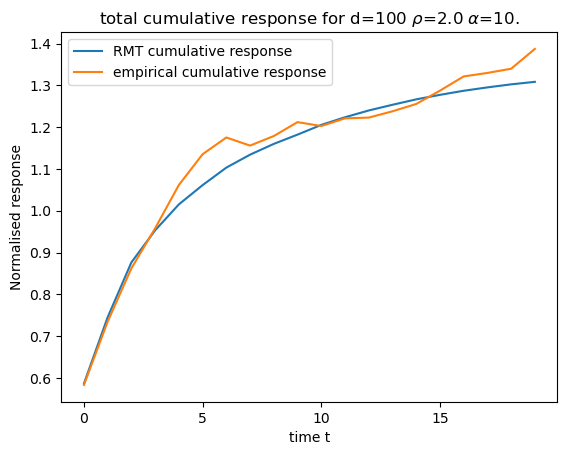

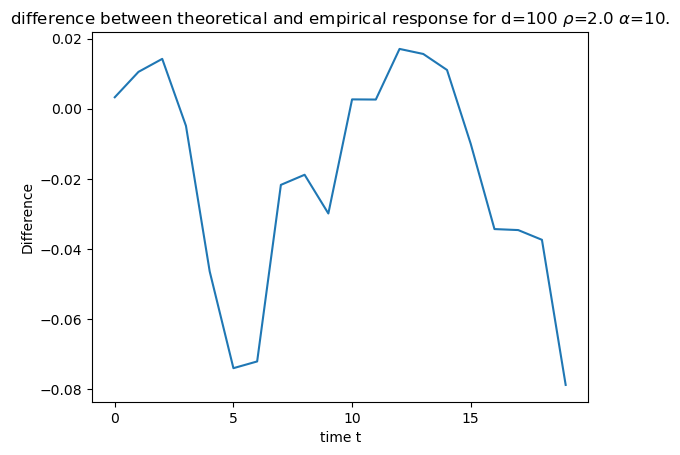

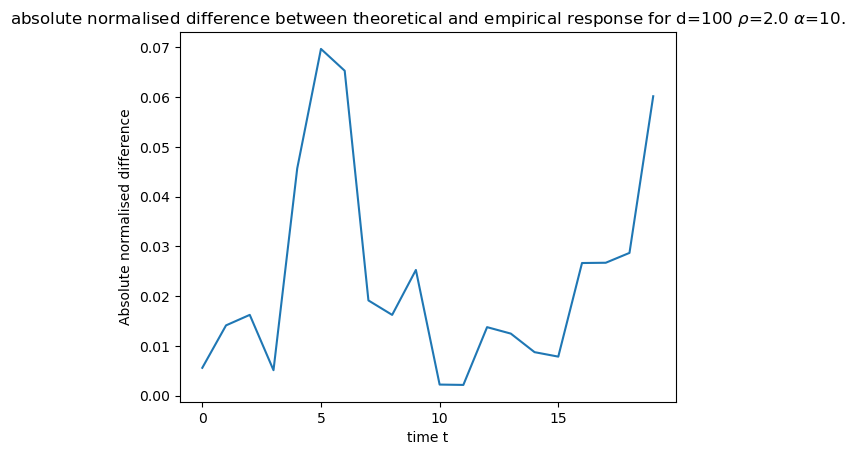

In [11]:
#Plot the cumulative response function with both the formalisms.

plot_cumulative_response(Cth, A, Neff, d, alpha, beta, time, sigma)

In [12]:
# Plot function, to compare the response between two edges with the two formalisms.

def plotcomparisons(RTrmt, bias, variance, RTcorr, time, beta, d, i="random", j="random"):
    """
    Plots a comparison of response functions inferred using RMT 
    and empirical correlation matrices, along with contributions from bias and variance.

    Parameters:
    - RTrmt (ndarray): Theoretical response matrices.
    - bias (ndarray): Bias component matrices.
    - variance (ndarray): Variance component matrices.
    - RTcorr (ndarray): Response matrix using correlation matrices.
    - time (int): Total number of time steps.
    - beta (float): Smoothing parameter.
    - d (int): Dimension of the system.
    - i (int or str): Index of the first dimension for plotting. If "random", a random index is chosen. Default is "random".
    - j (int or str): Index of the second dimension for plotting. If "random", a random index is chosen. Default is "random".

    Returns:
    - None. The function generates and displays the plot.
    """
    xrange = np.arange(0, time, 1/beta)
    
    # Choose random indices if not specified
    if i == "random":
        i = np.random.randint(0, d)
    if j == "random":
        j = np.random.randint(0, d)

    # Plot the response functions and contributions
    line2, = plt.plot(xrange, RTrmt[:, i, j], linestyle="--", marker='D', label="Response using RMT")
    line3, = plt.plot(xrange, bias[:, i, j], linestyle="--", color='green', alpha=0.5, label="Bias contribution")
    line4, = plt.plot(xrange, variance[:, i, j], color='red', linestyle="--", alpha=0.5, label="Variance contribution")
    line1, = plt.plot(xrange, RTcorr[:, i, j], linestyle="--", marker="X", label="Response using correlation matrices")
    print(len(RTrmt[:,i,j]))
    # Add legend, labels, and ticks
    plt.legend(handles=[line1, line2, line3, line4])
    plt.xticks(np.arange(0,time,5))
    plt.xlabel("time t")
    plt.ylabel(f'$R^2_{{{i},{j}}}(t)$')
    plt.title(f'Response from {j} to {i}')
    plt.show()
    #plt.title(f"Response function inferred by two different methods \n for alpha = {alpha}.")

20


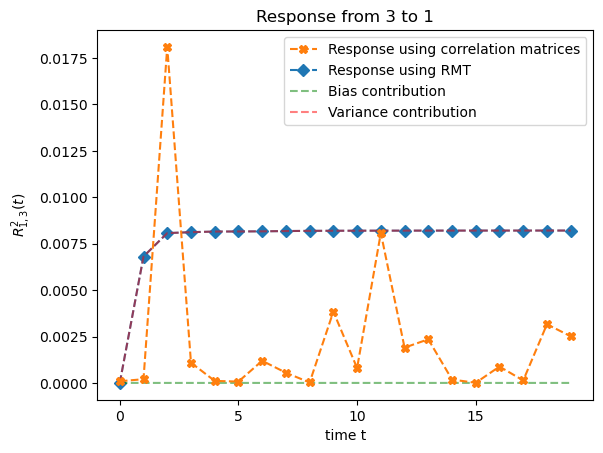

In [13]:
# Plot the response between two nodes, from j to i.
i = np.random.randint(0, d)
j = np.random.randint(0, d)
i = 1
j = 3
plotcomparisons(RTrmt, bias, variance, RTcorr**2,time,  beta, d, i, j)

In [14]:
def checkforedges_one_node(A, time, i, j):
    """
    Identifies the number of connexions from node j to i.

    Parameters:
    - R (ndarray): Adjacency matrix.
    - time (int): Number of time steps.
    - i (int): Index of the reaching node.
    - j (int): Index of the starting node.

    Returns:
    - listedges (list): A list containing the number of path from node j to i 
    """
    numberedges = np.zeros((time,))
    listpower = power(A, time, d)
    for t in range(time * beta):
        numberedges[t] = listpower[t,i,j]
    print(f"Show the power of the link between nodes {i} and {j} as a function of time. The first value of the list is related to t = 0.")
    return numberedges

In [15]:
nedges = checkforedges_one_node(A, time, i, j)

print(nedges)

Show the power of the link between nodes 1 and 3 as a function of time. The first value of the list is related to t = 0.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
